In [2]:
import numpy as np
import pandas as pd
import matplotlib as mplt
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding, Dropout, Flatten
# sequence data packages
from keras.preprocessing import sequence
import itertools
import random
import dataUtils as du

C:\Users\Yang\.conda\envs\test_speedcom\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
Using TensorFlow backend.


In [3]:
df=du.DataUtils.readData('temp_cleaned_data.tsv')
x_str, y_wl=du.DataUtils.get_xy(df,x_col_index=2,y_col_index=3)
maxlen = du.DataUtils.get_max_len(x_str)


   #      Name      name_smiles  Wavelength  Epsilon  Quantum Yield
0  1   Benzene      C1=CC=CC=C1      254.75      210          0.053
1  2   Toluene     CC1=CC=CC=C1      261.75     2860          0.170
2  3  o-Xylene    CC1=CC=CC=C1C      263.00      254          0.170
3  4  m-Xylene  CC1=CC(=CC=C1)C      265.00      284          0.130
4  5  p-Xylene  CC1=CC=C(C=C1)C      275.00      770          0.220


In [5]:
wordmap=du.DataUtils.get_wordmap(x_str)

In [6]:
x_encode=du.DataUtils.numeric_encoding(x_str,uniform_length=maxlen+5,word_map=wordmap)

In [7]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_wl, ratio=0.2)

(array([91., 57., 18., 25., 21., 23., 18.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

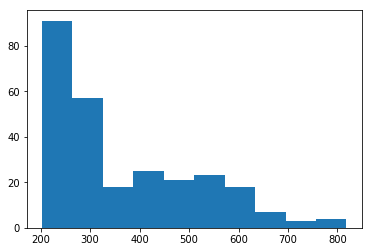

In [8]:
plt.hist(y_wl.tolist())

In [30]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [31]:
model.compile(loss='mean_absolute_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 279, 50)           2250      
_________________________________________________________________
lstm_4 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 279, 50)           2550      
_________________________________________________________________
flatten_2 (Flatten)          (None, 13950)             0         
__________

In [32]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=50)

Instructions for updating:
Use tf.cast instead.
Train on 213 samples, validate on 54 samples
Epoch 1/50
213/213 [==============================] - 5s 24ms/step - loss: 370.5999 - mean_absolute_error: 370.5999 - val_loss: 341.3432 - val_mean_absolute_error: 341.3432
Epoch 2/50
213/213 [==============================] - 3s 12ms/step - loss: 343.6850 - mean_absolute_error: 343.6850 - val_loss: 266.3703 - val_mean_absolute_error: 266.3703
Epoch 3/50
213/213 [==============================] - 3s 12ms/step - loss: 221.7783 - mean_absolute_error: 221.7783 - val_loss: 109.0955 - val_mean_absolute_error: 109.0955
Epoch 4/50
213/213 [==============================] - 2s 12ms/step - loss: 122.5941 - mean_absolute_error: 122.5941 - val_loss: 123.9458 - val_mean_absolute_error: 123.9458
Epoch 5/50
213/213 [==============================] - 3s 13ms/step - loss: 137.6057 - mean_absolute_error: 137.6057 - val_loss: 110.2413 - val_mean_absolute_error: 110.2413
Epoch 6/50
213/213 [======================

Epoch 47/50
213/213 [==============================] - 4s 19ms/step - loss: 104.0119 - mean_absolute_error: 104.0119 - val_loss: 95.7249 - val_mean_absolute_error: 95.7249
Epoch 48/50
213/213 [==============================] - 4s 18ms/step - loss: 102.9374 - mean_absolute_error: 102.9374 - val_loss: 97.8477 - val_mean_absolute_error: 97.8477
Epoch 49/50
213/213 [==============================] - 3s 16ms/step - loss: 100.1983 - mean_absolute_error: 100.1983 - val_loss: 97.6560 - val_mean_absolute_error: 97.6560
Epoch 50/50
213/213 [==============================] - 3s 16ms/step - loss: 97.6965 - mean_absolute_error: 97.6965 - val_loss: 99.2726 - val_mean_absolute_error: 99.2726


In [141]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [142]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr


In [59]:
def plot_model(x_train, x_test, y_train, y_test, model):
    fig, axes = plt.subplots(2)
    fig.dpi=100
    axes[0].scatter(y_train, model.predict(x_train).reshape(1,-1)-y_train, color = 'r',label='training')
    axes[1].scatter(y_test,model.predict(x_test).reshape(1,-1)-y_test, color = 'blue',label = 'test')
    fig.legend()
    plt.suptitle("error vs. y actual" )

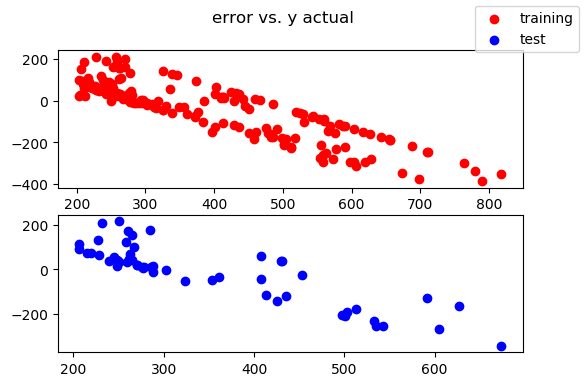

In [60]:
plot_model(X_train, X_test, y_train, y_test, model)

### consider transform y to make y more normal distributed

In [87]:
def tranform_log(x_list, b): #log(x-b)
    return np.log(list(x_list-b))

In [128]:
y_log = tranform_log(y_wl,y_wl.min()-10)

In [134]:
def inverse_log(transformed_x,b):
    return np.exp(transformed_x)+b

In [139]:
inverse_log(y_log, y_wl.min()-10)

array([254.75, 261.75, 263.  , 265.  , 275.  , 265.  , 278.  , 271.  ,
       271.  , 270.75, 220.  , 222.  , 242.  , 227.  , 241.  , 288.  ,
       251.  , 279.  , 265.  , 228.  , 258.  , 248.  , 236.  , 274.  ,
       277.  , 227.  , 222.  , 218.  , 310.25, 291.  , 240.  , 251.  ,
       263.  , 245.  , 302.  , 252.  , 283.  , 225.  , 316.  , 230.  ,
       442.  , 247.5 , 276.25, 294.75, 312.  , 251.  , 206.  , 209.  ,
       212.  , 245.  , 223.  , 278.  , 275.  , 356.25, 475.  , 578.  ,
       252.  , 241.  , 258.  , 372.5 , 270.25, 303.  , 228.  , 239.  ,
       245.  , 218.  , 227.  , 235.  , 278.75, 276.  , 293.75, 326.  ,
       330.  , 353.25, 432.25, 425.  , 372.  , 451.  , 251.  , 276.  ,
       227.  , 257.  , 265.  , 270.  , 215.  , 281.  , 238.  , 204.  ,
       219.  , 245.  , 217.  , 253.  , 231.75, 206.  , 278.  , 502.  ,
       413.  , 286.  , 336.  , 460.5 , 219.  , 413.  , 247.  , 349.  ,
       262.  , 257.5 , 274.25, 211.  , 278.  , 261.  , 243.  , 266.75,
      

(array([ 7.,  6., 15., 23., 55., 38., 19., 35., 50., 19.]),
 array([2.30258509, 2.71610175, 3.1296184 , 3.54313506, 3.95665172,
        4.37016837, 4.78368503, 5.19720168, 5.61071834, 6.02423499,
        6.43775165]),
 <a list of 10 Patch objects>)

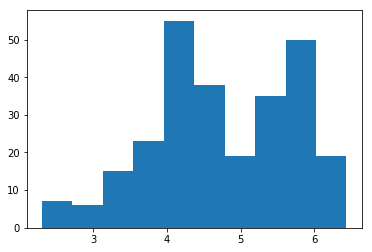

In [129]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_log, ratio=0.2)
plt.hist(y_log.tolist())

In [130]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=50)

Train on 213 samples, validate on 54 samples
Epoch 1/50
213/213 [==============================] - 3s 12ms/step - loss: 240.4158 - mean_absolute_error: 240.4158 - val_loss: 46.3202 - val_mean_absolute_error: 46.3202
Epoch 2/50
213/213 [==============================] - 3s 12ms/step - loss: 20.7427 - mean_absolute_error: 20.7427 - val_loss: 0.7557 - val_mean_absolute_error: 0.7557
Epoch 3/50
213/213 [==============================] - 3s 13ms/step - loss: 5.4793 - mean_absolute_error: 5.4793 - val_loss: 1.5305 - val_mean_absolute_error: 1.5305
Epoch 4/50
213/213 [==============================] - 3s 12ms/step - loss: 3.8924 - mean_absolute_error: 3.8924 - val_loss: 6.8295 - val_mean_absolute_error: 6.8295
Epoch 5/50
213/213 [==============================] - 3s 12ms/step - loss: 2.8602 - mean_absolute_error: 2.8602 - val_loss: 3.2327 - val_mean_absolute_error: 3.2327
Epoch 6/50
213/213 [==============================] - 3s 12ms/step - loss: 1.7289 - mean_absolute_error: 1.7289 - val_loss

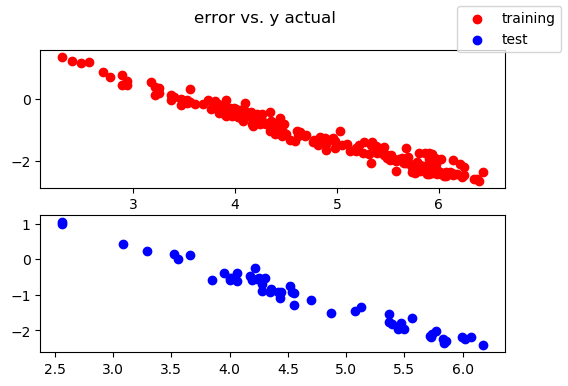

In [132]:
plot_model(X_train, X_test, y_train, y_test, model)

In [1]:
inverse_log(model.predict(X_train).reshape(1,-1), y_wl.min()-10)

NameError: name 'inverse_log' is not defined

Text(0.5, 0.98, 'error vs. y actual')

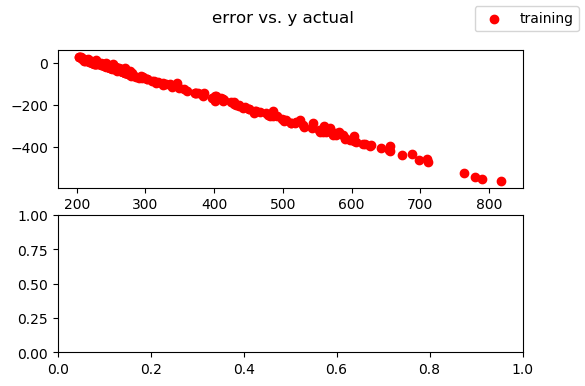

In [145]:
fig, axes = plt.subplots(2)
fig.dpi=100
axes[0].scatter(inverse_log(y_train, y_wl.min()-10), inverse_log(model.predict(X_train).reshape(1,-1), y_wl.min()-10)-inverse_log(y_train, y_wl.min()-10), color = 'r',label='training')

fig.legend()
plt.suptitle("error vs. y actual" )

### Try under sample the 200-400nm region to make the y more uniform

In [9]:
Y_category = (y_wl - 200) // 20

In [11]:
cls, counts = np.unique(Y_category, return_counts=True)
cls_counts = dict(zip(cls, counts))
print(cls_counts)

{0.0: 18, 1.0: 23, 2.0: 40, 3.0: 44, 4.0: 14, 5.0: 7, 6.0: 8, 7.0: 4, 8.0: 6, 9.0: 3, 10.0: 12, 11.0: 10, 12.0: 7, 13.0: 4, 14.0: 7, 15.0: 10, 16.0: 5, 17.0: 10, 18.0: 6, 19.0: 6, 20.0: 6, 21.0: 3, 22.0: 4, 23.0: 2, 24.0: 2, 25.0: 2, 28.0: 1, 29.0: 2, 30.0: 1}


#### To each category, keep less than 20 counts per category

In [40]:
data_cat=np.column_stack((x_str,y_wl,Y_category))

In [61]:
def subsampling(dataset, cls_max, cls_dict):
    out = []
    for row in dataset:
        cls = row[2]
        rInt = np.random.randint(0, cls_dict[cls])
        if rInt <= cls_max:
            out.append(row)
    return np.array(out)

subsampled = subsampling(data_cat, 10, cls_counts)

In [62]:
subsampled[:,1].shape

(189,)

In [63]:
x_encode=du.DataUtils.numeric_encoding(subsampled[:,0],uniform_length=maxlen+5,word_map=wordmap)

In [64]:
y_sub = subsampled[:,1]

(array([41., 29., 18., 25., 21., 23., 18.,  7.,  3.,  4.]),
 array([203. , 264.5, 326. , 387.5, 449. , 510.5, 572. , 633.5, 695. ,
        756.5, 818. ]),
 <a list of 10 Patch objects>)

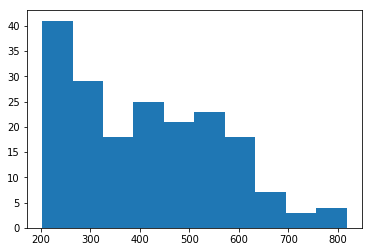

In [67]:
X_train, X_test, y_train, y_test=du.DataUtils.splitData(x_encode, y_sub, ratio=0.15)
plt.hist(y_sub.tolist())

In [70]:
hidden_size = 50
model = Sequential()
model.add(Embedding(len(wordmap), hidden_size, input_length=maxlen+5))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(LSTM(hidden_size, return_sequences=True))
model.add(Dropout(0.4))
model.add(Dense(hidden_size, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_absolute_error'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 279, 50)           2250      
_________________________________________________________________
lstm_4 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 279, 50)           20200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 279, 50)           0         
_________________________________________________________________
dense_3 (Dense)              (None, 279, 50)           2550      
_________________________________________________________________
flatten_2 (Flatten)          (None, 13950)             0         
__________

In [71]:
model.fit(X_train, y_train, batch_size=32, validation_data=(X_test, y_test), epochs=50)

Train on 160 samples, validate on 29 samples
Epoch 1/50
160/160 [==============================] - 4s 26ms/step - loss: 198562.2719 - mean_absolute_error: 419.9061 - val_loss: 164067.7656 - val_mean_absolute_error: 379.2515
Epoch 2/50
160/160 [==============================] - 2s 11ms/step - loss: 193748.8687 - mean_absolute_error: 413.9373 - val_loss: 150534.7188 - val_mean_absolute_error: 360.8287
Epoch 3/50
160/160 [==============================] - 2s 11ms/step - loss: 157656.6547 - mean_absolute_error: 366.3126 - val_loss: 92568.8984 - val_mean_absolute_error: 268.7489
Epoch 4/50
160/160 [==============================] - 2s 11ms/step - loss: 83147.7500 - mean_absolute_error: 246.3115 - val_loss: 35154.0078 - val_mean_absolute_error: 133.5898
Epoch 5/50
160/160 [==============================] - 2s 11ms/step - loss: 30540.1109 - mean_absolute_error: 139.6379 - val_loss: 26367.6211 - val_mean_absolute_error: 143.5896
Epoch 6/50
160/160 [==============================] - 2s 11ms/ste

Epoch 47/50
160/160 [==============================] - 2s 14ms/step - loss: 22313.2809 - mean_absolute_error: 126.6933 - val_loss: 21134.8574 - val_mean_absolute_error: 130.9054
Epoch 48/50
160/160 [==============================] - 2s 14ms/step - loss: 22432.8074 - mean_absolute_error: 126.7174 - val_loss: 20603.0156 - val_mean_absolute_error: 129.8223
Epoch 49/50
160/160 [==============================] - 2s 14ms/step - loss: 22217.7729 - mean_absolute_error: 125.7395 - val_loss: 20892.5215 - val_mean_absolute_error: 130.4620
Epoch 50/50
160/160 [==============================] - 2s 14ms/step - loss: 22078.0854 - mean_absolute_error: 125.7653 - val_loss: 21381.2891 - val_mean_absolute_error: 131.6530
